In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from vectorize import get_pos_tag, vectorize_word, vectorize_pos_n, get_freqs
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

train_alldata = pd.read_csv("./final_datasets/train-sents-final1.csv")
dev_alldata = pd.read_csv("./final_datasets/dev-sents-final1.csv")
test_alldata = pd.read_csv("./final_datasets/test-sents-final1.csv")

def data_stripper(arr):
    new_data = arr[:]
    new_data.columns = ['Bias Inducing Word','De-Biased Word','Sentence Pre-Edit','Sentence Post-Edit']
    return new_data[['Bias Inducing Word','Sentence Pre-Edit']]

train,dev,test = data_stripper(train_alldata),data_stripper(dev_alldata),data_stripper(test_alldata)
print(train[5:10])

  Bias Inducing Word                                  Sentence Pre-Edit
5           followed     relatively few parish clergy or laity followed
6       denomination  today the church of ireland is after the roman...
7        institution  the church of ireland came into existence as a...
8          civilians  controversy has arisen numerous times and from...
9             naming  the soviets formed a special commission which ...


In [11]:
def entailment_sorter(arr, length_entailing_predicate = 1, orderXY=True):
    '''
    Takes entailment dataset and distills it into usable information. Use params to get
    the output you want. X 'word' Y = True means first argument is X, second is Y. False
    means first argument is Y and second is X. 
    If orderXY = True it includes the last 2 headers:
    Entailing Predicate, Entailed Predicate, X.Y=T/F Entailing Pred., X.Y=T/F Entailed Pred.
    '''
    # TODO: what happens when we want a longer length_entailing_predicate?
    if orderXY:
        data = []
        for e in arr:
            x, y = e.split('\t')
            if len(x.split()) <= length_entailing_predicate:
                x_arg, y_arg = True, True
                if '@R@' in x: x_arg = False
                if '@R@' in y: y_arg = False
                data.append([x.replace('@R@',''), y.replace('@R@',''), x_arg, y_arg])
        df = pd.DataFrame(data, columns=['Entailing Predicate','Entailed Predicate',
                                         'X.Y=T/F Entailing Pred.','X.Y=T/F Entailed Pred.'])
        return df
    else:
        data = []
        for e in arr:
            x, y = e.split('\t')
            if len(x.split()) <= length_entailing_predicate:
                data.append([x.replace('@R@',''), y.replace('@R@','')])
        df = pd.DataFrame(data, columns=['Entailing Predicate','Entailed Predicate'])
        return df

In [12]:
bias_lexicon_file = open('./bias-lexicon/bias-lexicon.txt','r')
implicatives_file = open('./bias_related_lexicons/implicatives_karttunen1971.txt','r')
assertives_file = open('./bias_related_lexicons/assertives_hooper1975.txt','r')
factives_file = open('./bias_related_lexicons/factives_hooper1975.txt','r')
hedges_file = open('./bias_related_lexicons/hedges_hyland2005.txt','r')
other_file = open('./bias_related_lexicons/other_lexicons.txt','r')
report_verbs_file = open('./bias_related_lexicons/report_verbs.txt','r')
entailments_file = open('./entailments/reverb_global_clsf_all_tncf_lambda_0.1.txt','r')
strong_subjectives_file = open('./subjectivity_clues/strongsubj.csv','r')
weak_subjectives_file = open('./subjectivity_clues/weaksubj.csv','r')
bias_lexicon = bias_lexicon_file.read().strip().split('\n')
assertives = assertives_file.read().strip().split('\n')[7:]
factives = factives_file.read().strip().split('\n')[7:]
hedges = hedges_file.read().strip().split('\n')[7:]
other_lexicon = other_file.read().strip().split('\n')
report_verbs = report_verbs_file.read().strip().split('\n')[9:]
entailments_prestrip = entailments_file.read().strip().split('\n')

# Strong/weak subjectives
# TODO: Word, Priorpolarity (PP) headers
strong_subjectives = list(set(strong_subjectives_file.read().strip().split('\n')))
weak_subjectives = list(set(weak_subjectives_file.read().strip().split('\n')))
strong_subjectives_withPP = [strong_subjectives[i].split(',') for i in range(len(strong_subjectives))]
weak_subjectives_withPP = [weak_subjectives[i].split(',') for i in range(len(weak_subjectives))]
strong_subjectives_list, weak_subjectives_list = [], []
for ss_row, ws_row in zip(strong_subjectives_withPP, weak_subjectives_withPP):
    strong_subjectives_list.append(ss_row[0])
    weak_subjectives_list.append(ws_row[0])

# Using Entailments function
entailments = entailment_sorter(entailments_prestrip, length_entailing_predicate = 1, 
                                orderXY=True)

entailing_predicates = list(entailments['Entailing Predicate'])


In [96]:
def isInList(dictionaries, word, n_gram):
    '''
    Pass in array of dictionaries, word under instpection and n_gram of words - 
    either [3,4,5]-gram length.
    Returns True/False vector if word and if surrounding words are in the dictionary. 
    Vector length is 2 x (# of dictionaries), first T/F is if word is in dictionary, second
    T/F if any of the immediately surrounding word(s) is in dictionary.
    Make sure you input dictionaries in the correct order.
    True = 1, False = 0
    '''
    tf_vector = []
    len_ngram, words_ngram = len(n_gram.split()), np.array(n_gram.split())
    surrounding_words = []
    if len_ngram == 3:
        if word == words_ngram[0]: surrounding_words.append(words_ngram[1])
        else: surrounding_words.append(words_ngram[-2])
    elif len_ngram == 4:
        # n_gram is 4 words long, target word is either in position 2 or 3 
        word_index = np.where(word == words_ngram)[0]
        if 1 in word_index: # target word is 2nd word
            surrounding_words.append(words_ngram[0])
            surrounding_words.append(words_ngram[2])
        elif 2 in word_index: # target word is 3rd word
            surrounding_words.append(words_ngram[1])
            surrounding_words.append(words_ngram[3])
        # only issue is if the target word repeats?
    elif len_ngram == 5:
        # n_gram is 5 words long, target word is in the middle
        surrounding_words.append(words_ngram[1]) 
        surrounding_words.append(words_ngram[3])

    for dictionary in dictionaries:
        if word in dictionary: tf_vector.append(1)
        else: tf_vector.append(0)
        for surrounding_word in surrounding_words:
            if surrounding_word in dictionary:
                tf_vector.append(1)
                break
            else:
                # If last word in surrounding_words list, then neither word is in dictionary
                if surrounding_word == surrounding_words[-1]:
                    tf_vector.append(0)
                    break
    return tf_vector

def isInBiasLexicon(word,dictionary=bias_lexicon):
    if word in dictionary: return 1
    return 0
    

In [14]:
print(isInList([assertives,factives,hedges,report_verbs,
          entailing_predicates,strong_subjectives_list,weak_subjectives_list],
         'murder','a gruesome murder was committed'))
print(isInBiasLexicon('murder'))

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
1


In [15]:
def get_context(pair, tagged_sent):
    index, max_index = tagged_sent.index(pair), len(tagged_sent)-1
    context = ''
    for n in range(-2, 3):
        if (index + n < 0) or (index + n > max_index):
            continue
        else:
            context += tagged_sent[index+n][0] + ' '
    return context

In [293]:
def vectorize_df(df, POS_FREQ_DIST, WORD_FREQ_DIST, corpus_list, bias_lexicon_list):
    df['tagged_sent'] = df.apply(get_pos_tag, axis = 1)
    attiribute_matrix = []
    result_vector = []
    for row in df.index:
        tagged_sent = df['tagged_sent'].iloc[row]
        # FIXME: this definition of word may not match definition in 'Bias Inducing Word'
        for pair in tagged_sent:
            current_vector = []
            current_vector.append(vectorize_word(pair[0], WORD_FREQ_DIST))
            current_index = tagged_sent.index(pair)
            for n in range(-1,2):
                if (current_index + n < 0) or (current_index + n >= len(tagged_sent)):
                    True
                    current_vector.append(0)
                else:
                    pair_plus_n = tagged_sent[current_index+n]
                    current_vector.append(vectorize_pos_n(pair_plus_n[1], n, POS_FREQ_DIST))
            corpus_tf = isInList(corpus_list, pair[0], get_context(pair, tagged_sent))
            for tf in corpus_tf: current_vector.append(tf)
            current_vector.append(isInBiasLexicon(pair[0]))
            if len(current_vector) > 11: # 3 <= len n_gram <= 5... T/F vector will be short otherwise
                if (pair[0] == df['Bias Inducing Word'].iloc[row]) == True: 
                    result_vector.append(1)
                else: result_vector.append(0)
                attiribute_matrix.append(current_vector)
    return attiribute_matrix, result_vector

In [17]:
POS_FREQ_DIST, WORD_FREQ_DIST = get_freqs("./final_datasets/train-sents-final1.csv")
corpus_list = [assertives,factives,hedges,report_verbs,
          entailing_predicates,strong_subjectives_list,weak_subjectives_list]
bias_lexicon_list = bias_lexicon

In [294]:
attiribute_matrix_train, result_vector_train = vectorize_df(train, POS_FREQ_DIST, WORD_FREQ_DIST, corpus_list, bias_lexicon_list)

In [327]:
def resample(attiribute_matrix, result_vector, number):
    df = pd.DataFrame(attiribute_matrix_train)
    df['results'] = result_vector_train
    rows = []
    for row in df.iterrows():
        if row[1]['results'] == 1:
            for i in range(number):
                df_row = pd.DataFrame([row[1].values])
                df_row['results'] = df_row[19]
                df_row = df_row.drop(19, axis = 1)
                df = df.append(df_row)
    return df.dropna()

In [342]:
df_resampled = resample(attiribute_matrix_train, result_vector_train, 4)
df_resampled.corr(method='spearman')['results'].to_frame()

,results
0,0.607344
1,-0.052171
2,0.257555
3,-0.083755
4,0.055926
5,-0.006872
6,0.009516
7,-0.000367
8,0.067934
9,-0.003460


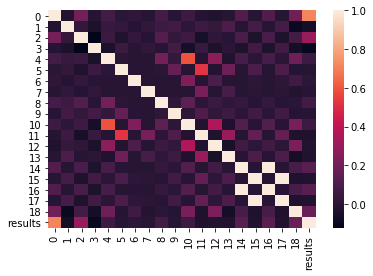

In [328]:
corr = df_resampled.corr(method='spearman')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [343]:
attiribute_matrix_train_re = df_resampled.iloc[:, 0:19].values
result_vector_train_re = df_resampled['results'].values

In [28]:
def perumutation_feature_selection(attiribute_matrix, result_vector):       
    model = LogisticRegression()
    model.fit(attiribute_matrix, result_vector)
    #Permute the variables feed to model to determine importance
    perm_results = permutation_importance(model, attiribute_matrix, result_vector, scoring='neg_mean_squared_error')
    #Get importance score
    importance = perm_results.importances_mean
    print(importance)
    pyplot.bar([i for i in range(len(importance))], importance)
    pyplot.show()

[ 2.33481262e-01  1.44054663e-03  1.68709496e-03 -1.02141448e-04
  1.76105945e-05 -7.04423781e-05 -1.05663567e-05  1.51451113e-04
  4.50831220e-04  4.22654269e-05 -2.04282897e-04  0.00000000e+00
 -8.45308538e-05 -1.09185686e-04  7.74866159e-05 -1.44406875e-04
  7.74866159e-05 -1.44406875e-04  2.32459848e-03]


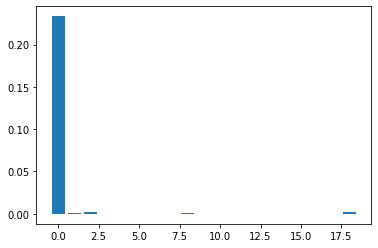

In [330]:
perumutation_feature_selection(attiribute_matrix_train_re, result_vector_train_re)

In [344]:
model = LogisticRegression()
model.fit(attiribute_matrix_train_re, result_vector_train_re)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [361]:
model.coef_

array([[21.55073922, -0.74107236,  0.7151217 ,  0.09394741,  0.36424229,
         0.28315444,  0.08809359,  0.79133671,  0.43386657,  0.05407101,
        -0.13984722, -0.03586013, -0.21199553, -0.11641143,  0.07567439,
         0.07552898,  0.07567439,  0.07552898,  0.61768542]])

In [334]:
attiribute_matrix_dev, result_vector_dev = vectorize_df(dev, POS_FREQ_DIST, WORD_FREQ_DIST, corpus_list, bias_lexicon_list)

In [364]:
precision_recall_fscore_support(model.predict(attiribute_matrix_dev), result_vector_dev)

(array([0.97499342, 0.15037594]),
 array([0.9703956 , 0.17391304]),
 array([0.97268908, 0.16129032]),
 array([3817,  115]))

In [358]:
len(result_vector_dev)

3932

In [359]:
right = 0
count = 0
predictions = model.predict(attiribute_matrix_dev)
for i in range(len(predictions)):
    if result_vector_dev[i] == 1:
        count +=1.0
        if result_vector_dev[i]  == predictions[i]:
            right+=1.0
right/count

0.15037593984962405

In [360]:
wrong = 0
count = 0
predictions = model.predict(attiribute_matrix_dev)
for i in range(len(predictions)):
    if predictions[i] == 1:
        count +=1.0
        if result_vector_dev[i]  != predictions[i]:
            wrong += 1.0
wrong/count

0.8260869565217391